In [223]:
import pandas as pd
import numpy as np
import geojson
from datetime import datetime, time
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go

References:

- _Stack Overflow_ :
    - https://stackoverflow.com/questions/50375985/pandas-add-column-with-value-based-on-condition-based-on-other-columns
    - https://stackoverflow.com/questions/19384532/get-statistics-for-each-group-such-as-count-mean-etc-using-pandas-groupby
    - https://stackoverflow.com/questions/44111307/python-pandas-count-rows-based-on-column
    - https://stackoverflow.com/questions/47502891/removing-group-header-after-pandas-aggregation
    - https://stackoverflow.com/questions/14529838/apply-multiple-functions-to-multiple-groupby-columns

- _Others_ :
    - https://www.kite.com/python/answers/how-to-select-rows-by-multiple-label-conditions-with-pandas-loc-in-python
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.astype.html
    - https://datatofish.com/line-chart-python-matplotlib/
    - https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.sort_values.html
    - https://github.com/rahulrohri/final_project_2020Sp
    - https://studio.mapbox.com/
    - https://plotly.com/python/scattermapbox/
    - https://data.beta.nyc/dataset/nyc-zip-code-tabulation-areas/resource/6df127b1-6d04-4bb7-b983-07402a2c3f90
    - https://plotly.com/python/mapbox-county-choropleth/
    - https://medium.com/@ingeh/markdown-for-jupyter-notebooks-cheatsheet-386c05aeebed

In [193]:
NYC_collision_crashes_file = "Motor_Vehicle_Collisions_-_Crashes.csv"
NYC_collision_persons_file = "Motor_Vehicle_Collisions_-_Person.csv"
Population_by_age_2010 = 'population_by_age_2010.csv'

In [4]:
def load_collision_data(crashes_file, persons_file):
    crashes = pd.read_csv(crashes_file, low_memory=False)
    persons = pd.read_csv(persons_file, low_memory=False)
    
    crashes.loc[:, 'CRASH_YEAR'] = crashes['CRASH DATE'].astype(np.str_).apply(lambda x: int(x.split('/')[-1]))
    
    return crashes, persons

In [5]:
crashes, persons = load_collision_data(NYC_collision_crashes_file, NYC_collision_persons_file)

In [6]:
crashes.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'CRASH_YEAR'],
      dtype='object')

In [7]:
persons.columns

Index(['UNIQUE_ID', 'COLLISION_ID', 'CRASH_DATE', 'CRASH_TIME', 'PERSON_ID',
       'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID', 'PERSON_AGE', 'EJECTION',
       'EMOTIONAL_STATUS', 'BODILY_INJURY', 'POSITION_IN_VEHICLE',
       'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION', 'COMPLAINT',
       'PED_ROLE', 'CONTRIBUTING_FACTOR_1', 'CONTRIBUTING_FACTOR_2',
       'PERSON_SEX'],
      dtype='object')

## Hypothesis:
#### Of all collisions occurring late in the night (between 12 am - 5 am), the majority are caused due to overspeeding.

In [8]:
night_crash_data = None

In [9]:
def get_night_crashes(crashes):
    
    time_data = crashes['CRASH TIME']
    crashes['CRASH TIME'] = crashes['CRASH TIME'].apply(lambda x: datetime.strptime(x, "%H:%M").time())

    night_crash_data = crashes[(crashes['CRASH TIME'] < time(5, 0, 0))]

    return night_crash_data

In [10]:
def check_for_unsafe_speed(night_crash_data):
    night_crash_data = night_crash_data.assign(hasUnsafeSpeed=False)
    night_crash_data.loc[((night_crash_data['CONTRIBUTING FACTOR VEHICLE 1']=='Unsafe Speed') | 
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 2']=='Unsafe Speed') | 
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 3']=='Unsafe Speed') | 
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 4']=='Unsafe Speed') | 
                          (night_crash_data['CONTRIBUTING FACTOR VEHICLE 5']=='Unsafe Speed')), 
                         'hasUnsafeSpeed'] = True
    
    return night_crash_data

In [11]:
def calculate_percentage_of_speedy_collisions(night_crash_data):
    unsafe_speed_metrics = night_crash_data['hasUnsafeSpeed'].value_counts().to_frame()
    percentage_unsafe_speed_collisions = unsafe_speed_metrics.iloc[1]*100/night_crash_data.shape[0]
    
    return percentage_unsafe_speed_collisions

In [12]:
def calculate_invalid_collision_percentage(night_crash_data):
    
    unwanted_contributing_factors = ['1','80','Unspecified']
    
    night_crash_data['isUnspecified'] = np.where((((
        night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].isin(unwanted_contributing_factors)) | 
        (night_crash_data['CONTRIBUTING FACTOR VEHICLE 1'].isnull())) & 
        ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].isin(unwanted_contributing_factors)) | 
         (night_crash_data['CONTRIBUTING FACTOR VEHICLE 2'].isnull())) & 
        ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isin(unwanted_contributing_factors))  | 
         (night_crash_data['CONTRIBUTING FACTOR VEHICLE 3'].isnull())) & 
        ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isin(unwanted_contributing_factors))  | 
         (night_crash_data['CONTRIBUTING FACTOR VEHICLE 4'].isnull())) & 
        ((night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isin(unwanted_contributing_factors))  | 
         (night_crash_data['CONTRIBUTING FACTOR VEHICLE 5'].isnull()))), True, False)
    
    invalid_night_crash_data_metrics = night_crash_data['isUnspecified'].value_counts().to_frame()
    
    percentage_invalid_collision_data = invalid_night_crash_data_metrics.iloc[1]*100/night_crash_data.shape[0]
    
    return percentage_invalid_collision_data

In [13]:
night_crash_data = get_night_crashes(crashes)

In [14]:
night_crash_unsafe_speed_data = check_for_unsafe_speed(night_crash_data)

In [15]:
percentage_unsafe_speed_collisions = calculate_percentage_of_speedy_collisions(night_crash_unsafe_speed_data)

In [16]:
percentage_unsafe_speed_collisions

hasUnsafeSpeed    2.687928
Name: True, dtype: float64

In [17]:
percentage_invalid_collision_data = calculate_invalid_collision_percentage(night_crash_data)

C:\Users\agarw\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app


In [18]:
percentage_invalid_collision_data

isUnspecified    34.79346
Name: True, dtype: float64

## Hypothesis:

#### Of all crashes, a majority number is caused by persons between the age of 16-25.

In [19]:
def get_merged_crashes_persons(crashes, persons):
    crashes_persons = pd.merge(crashes, persons, left_on='COLLISION_ID', right_on='COLLISION_ID', how='inner')
    crashes_persons.loc[:, 'CRASH_YEAR'] = crashes_persons['CRASH_DATE'].astype(np.str_).apply(lambda x: x.split('/')[-1])
    del crashes_persons['CRASH_DATE']
    del crashes_persons['CRASH_TIME']
    del crashes_persons['UNIQUE_ID']
    return crashes_persons

In [20]:
crashes_persons = get_merged_crashes_persons(crashes, persons)

In [21]:
crashes_persons.columns

Index(['CRASH DATE', 'CRASH TIME', 'BOROUGH', 'ZIP CODE', 'LATITUDE',
       'LONGITUDE', 'LOCATION', 'ON STREET NAME', 'CROSS STREET NAME',
       'OFF STREET NAME', 'NUMBER OF PERSONS INJURED',
       'NUMBER OF PERSONS KILLED', 'NUMBER OF PEDESTRIANS INJURED',
       'NUMBER OF PEDESTRIANS KILLED', 'NUMBER OF CYCLIST INJURED',
       'NUMBER OF CYCLIST KILLED', 'NUMBER OF MOTORIST INJURED',
       'NUMBER OF MOTORIST KILLED', 'CONTRIBUTING FACTOR VEHICLE 1',
       'CONTRIBUTING FACTOR VEHICLE 2', 'CONTRIBUTING FACTOR VEHICLE 3',
       'CONTRIBUTING FACTOR VEHICLE 4', 'CONTRIBUTING FACTOR VEHICLE 5',
       'COLLISION_ID', 'VEHICLE TYPE CODE 1', 'VEHICLE TYPE CODE 2',
       'VEHICLE TYPE CODE 3', 'VEHICLE TYPE CODE 4', 'VEHICLE TYPE CODE 5',
       'CRASH_YEAR', 'PERSON_ID', 'PERSON_TYPE', 'PERSON_INJURY', 'VEHICLE_ID',
       'PERSON_AGE', 'EJECTION', 'EMOTIONAL_STATUS', 'BODILY_INJURY',
       'POSITION_IN_VEHICLE', 'SAFETY_EQUIPMENT', 'PED_LOCATION', 'PED_ACTION',
       'COMPL

In [22]:
crashes_persons['PERSON_TYPE'].unique()

array(['Occupant', 'Pedestrian', 'Bicyclist'], dtype=object)

In [23]:
# check if there are entries where person is of 'Bicyclist' type and vehicle id is None
crashes_persons[(crashes_persons['VEHICLE_ID'].isna()) & 
                (crashes_persons['PERSON_TYPE'] == 'Bicyclist')][['COLLISION_ID', 'PERSON_TYPE', 'POSITION_IN_VEHICLE']]

,COLLISION_ID,PERSON_TYPE,POSITION_IN_VEHICLE


In [24]:
# dropping all rows where there is no vehicle ID present
crashes_persons.drop(crashes_persons.loc[crashes_persons['VEHICLE_ID'].isna()].index, inplace=True)

In [25]:
def get_crashes_persons_age_grouping_data(crashes_persons, columns):
    crashes_persons_age_grouping = crashes_persons[crashes_persons['POSITION_IN_VEHICLE'] == 'Driver'][columns]
    crashes_persons_age_grouping.loc[:, 'age16-25'] = np.where((crashes_persons_age_grouping['PERSON_AGE'] > 15) & 
                                                               (crashes_persons_age_grouping['PERSON_AGE'] < 26), True, False)
    return crashes_persons_age_grouping

In [97]:
columns = ['CRASH_YEAR', 'PERSON_AGE']
crashes_persons_age_grouping = get_crashes_persons_age_grouping_data(crashes_persons, columns)

In [98]:
crashes_persons_age_grouping.head()

,CRASH_YEAR,PERSON_AGE,age16-25
1,2018,57.0,False
5,2018,38.0,False
6,2018,39.0,False
8,2018,43.0,False
9,2018,83.0,False


In [89]:
crashes_persons_age_grouping[crashes_persons_age_grouping['PERSON_AGE'] < 16]['PERSON_AGE'].unique()

array([   0.,   15.,   10.,   13.,   12.,    2.,    8.,    1., -947.,
       -518.,    9., -936.,   11., -597.,   14., -968., -970., -594.,
       -965., -593.,    3.,    7., -938., -534., -296.,    6., -177.,
       -978.,    5., -595., -798., -714.,    4., -953., -217., -944.,
       -417., -517., -596., -592., -964., -797., -617., -969., -935.,
       -962., -533., -977., -959., -955., -963., -974., -973., -960.,
       -966., -536., -178., -971., -967., -972., -948., -899., -942.,
       -951., -975., -941., -945., -184., -618., -931., -957., -946.,
       -717., -934., -954., -626., -949., -976., -117., -958., -933.,
       -961., -294., -722., -194., -956., -418., -317., -716., -537.,
       -179., -939., -922., -999., -979., -943., -293., -181., -180.,
       -950., -198., -199., -718., -715., -174., -982., -927., -930.,
       -255., -952., -929., -295.])

In [90]:
crashes_persons_age_grouping[crashes_persons_age_grouping['PERSON_AGE'] > 99]['PERSON_AGE'].unique()

array([ 110.,  120., 1041.,  107.,  118., 1026., 1069., 1060., 1024.,
       1043., 6237., 6229.,  244.,  243., 1086., 1032., 1047.,  817.,
        316.,  318.,  324.,  321.,  338., 6030.,  845., 1027., 1037.,
        117., 1820., 1033.,  100.,  108.,  838.,  836.,  132.,  113.,
       1058., 1073., 6043., 6040., 1213., 1214.,  847.,  840., 6032.,
       6027.,  260.,  207.,  860.,  853.,  116.,  948.,  925., 1054.,
       1053.,  249.,  220., 1065., 1034., 1031., 1044., 5240., 5230.,
       2219., 5212.,  999.,  119.,  111., 6122.,  148., 7202., 7239.,
       1064.,  102.,  122., 1039., 5511., 5556., 7046., 1046., 1050.,
       4029., 4022., 1080., 1059.,  230.,  210.,  252.,  253., 7211.,
       7230., 7207.,  212., 3247.,  242.,  232.,  274.,  981.,  929.,
        938.,  951., 6210., 1036., 6035., 6047., 1045.,  156., 3021.,
        109., 6024., 6065., 5221., 5241., 6055., 2211.,  209.,  850.,
        219.,  211.,  245.,  831., 5234., 7082., 1020., 5048., 9999.,
       1056., 1022.,

In [102]:
crashes_persons_age_grouping.loc[:, 'ageBelow16'] = np.where(crashes_persons_age_grouping['PERSON_AGE'] < 16, True, False)
crashes_persons_age_grouping['ageBelow16'].value_counts()

False    1465016
True        8528
Name: ageBelow16, dtype: int64

In [103]:
crashes_persons_age_grouping.loc[:, 'ageAbove99'] = np.where(crashes_persons_age_grouping['PERSON_AGE'] > 99, True, False)
crashes_persons_age_grouping['ageAbove99'].value_counts()

False    1472186
True        1358
Name: ageAbove99, dtype: int64

In [93]:
crashes_persons_age_grouping['PERSON_AGE'].isna().sum()

5066

In [104]:
# Dropping all rows with age < 16, age > 99 and age Nan
crashes_persons_age_grouping.drop(
    crashes_persons_age_grouping.loc[(crashes_persons_age_grouping['ageBelow16']) | 
                                     (crashes_persons_age_grouping['ageAbove99']) | 
                                     (crashes_persons_age_grouping['PERSON_AGE'].isna())].index, inplace=True)

In [95]:
crashes_persons_age_grouping['PERSON_AGE'].unique()

array([57., 38., 39., 43., 83., 32., 61., 26., 48., 44., 76., 59., 27.,
       36., 29., 65., 69., 46., 42., 40., 33., 21., 58., 45., 31., 78.,
       30., 54., 24., 22., 64., 34., 51., 52., 35., 18., 53., 77., 28.,
       81., 73., 37., 87., 41., 74., 66., 60., 72., 62., 23., 63., 56.,
       50., 25., 71., 47., 55., 19., 20., 67., 49., 70., 68., 79., 80.,
       16., 86., 82., 92., 75., 84., 88., 85., 17., 89., 93., 90., 94.,
       91., 95., 98., 96., 99., 97.])

Using the 2010 population by age demographics of NYC for getting the population proportions by age

In [241]:
def get_population_proportion_data(filename):
    population_by_age_2010 = pd.read_csv(filename)
    ages = [str(i) for i in range(16, 26)]
    population_by_age_2010.loc[:, 'age16-25'] = np.where(population_by_age_2010['age'].isin(ages), True, False)
    population_by_age_2010.loc[:, 'proportion'] = population_by_age_2010['population'] / population_by_age_2010['population'].sum()
    return population_by_age_2010

In [242]:
population_by_age_2010 = get_population_proportion_data(Population_by_age_2010)

In [243]:
# Proportion of population for the age group 16-25
pop_prop_16_25 = population_by_age_2010[population_by_age_2010['age16-25']]['proportion'].sum()
pop_prop_16_25

0.15003046433617656

In [244]:
# Proportion of population for the age group 26-99
ages = [str(i) for i in range(26, 100)]
pop_prop_26_99 = population_by_age_2010[population_by_age_2010['age'].isin(ages)]['proportion'].sum()
pop_prop_26_99

0.6589243257571468

In [245]:
def get_grouped_crashes_age_group_data(crashes_persons_age_grouping, pop_prop_16_25, pop_prop_26_99):
    crashes_by_year_age = crashes_persons_age_grouping.groupby(['CRASH_YEAR', 'PERSON_AGE']).size().reset_index()
    crashes_by_year_age = crashes_by_year_age.rename(columns={0: 'crashes'})
    crashes_by_year_age.loc[:, 'age_group'] = np.where((crashes_by_year_age['PERSON_AGE'] > 15) & 
                                                  (crashes_by_year_age['PERSON_AGE'] < 26), '16-25', '26-99')
    
    crashes_by_year_age_grouped = crashes_by_year_age.groupby(['CRASH_YEAR', 'age_group']).agg({'crashes': ['sum']}).reset_index()
    crashes_by_year_age_grouped.columns = crashes_by_year_age_grouped.columns.droplevel(1)
    crashes_by_year_age_grouped = crashes_by_year_age_grouped.pivot(index='CRASH_YEAR', columns='age_group', values='crashes')
    crashes_by_year_age_grouped.loc[:, 'total'] = crashes_by_year_age_grouped['26-99'] + crashes_by_year_age_grouped['16-25']
    crashes_by_year_age_grouped.loc[:, 'norm_16-25'] = crashes_by_year_age_grouped['16-25'] / (crashes_by_year_age_grouped['total'].sum() * pop_prop_16_25)
    crashes_by_year_age_grouped.loc[:, 'norm_26-99'] = crashes_by_year_age_grouped['26-99'] / (crashes_by_year_age_grouped['total'].sum() * pop_prop_26_99)
    
    return crashes_by_year_age_grouped.reset_index()

In [250]:
crashes_by_year_age_grouped = get_grouped_crashes_age_group_data(crashes_persons_age_grouping, pop_prop_16_25, pop_prop_26_99)
crashes_by_year_age_grouped

age_group,CRASH_YEAR,16-25,26-99,total,norm_16-25,norm_26-99
0,2012,12,19,31,0.000055,0.000020
1,2013,11,50,61,0.000050,0.000052
2,2014,30,124,154,0.000137,0.000129
3,2015,45,174,219,0.000206,0.000181
4,2016,41268,245473,286741,0.188582,0.255408
5,2017,50792,305532,356324,0.232104,0.317898
6,2018,49200,308564,357764,0.224829,0.321052
7,2019,44203,279581,323784,0.201994,0.290896
8,2020,21468,112046,133514,0.098102,0.116581


In [251]:
def plot_crashes_age_groups(crashes_by_year_age_grouped):
    fig = go.Figure()

    fig.add_trace(go.Scatter(
        x=crashes_by_year_age_grouped['CRASH_YEAR'].tolist(),
        y=crashes_by_year_age_grouped['norm_16-25'].tolist(),
        name="Normalized number of crashes for age group 16-25"
    ))


    fig.add_trace(go.Scatter(
        x=crashes_by_year_age_grouped['CRASH_YEAR'].tolist(),
        y=crashes_by_year_age_grouped['norm_26-99'].tolist(),
        name="Normalized number of crashes for age group 26-99"
    ))

    fig.update_layout(
        title="Plot of normalized number of crashes per year for age groups 16-25 and 26-99",
        xaxis_title="Year",
        yaxis_title="Normalized number of crashes",
        legend_title="Legend"
    )

    fig.show()

In [252]:
plot_crashes_age_groups(crashes_by_year_age_grouped)

## Hypothesis

#### The number of collisions increased with an increase in population

Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population

In [34]:
def get_NYC_population_data():
    #Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population
    
    NYC_Population_data = {'Year':  [2012,2013,2014,2015,2016,2017,2018,2019,2020],
        'Population': [8348030,8398740,8437390,8468180,8475980,8438270, 8398750, 8361040, 8323340],
        }

    NYC_Population = pd.DataFrame (NYC_Population_data, columns = ['Year','Population'])
    
    NYC_area = 300.4 #(in sq miles) Source - https://worldpopulationreview.com/us-cities/new-york-city-ny-population
    
    NYC_Population['Population_Density'] = NYC_Population['Population'].apply(lambda x: x/NYC_area)
    
    return NYC_Population

In [35]:
def get_total_crashes_per_year(crashes):
    crashes_data = crashes.copy()
    crashes_total = crashes_data.groupby(['CRASH_YEAR'], sort=False).size().reset_index(name='Total_Crashes')
    crashes_total['CRASH_YEAR'] = crashes_total['CRASH_YEAR'].astype('int64')
    
    crashes_total = crashes_total.sort_values(by=['CRASH_YEAR'])
    
    return crashes_total

In [36]:
def calculate_crashes_per_capita(crashes_total, NYC_Population):
    crashes_population = pd.merge(crashes_total, NYC_Population, left_on='CRASH_YEAR', right_on='Year', how='inner')
    
    crashes_population.loc[:, 'Crashes_per_capita'] = crashes_population['Total_Crashes']/crashes_population['Population']
    
    return crashes_population

In [37]:
def plot_crashes_per_capita_vs_year(crashes_population):
    plt.plot(crashes_population['Year'], crashes_population['Crashes_per_capita'], color='red', marker='o')
    plt.title('Crashes_per_Capita Vs Year for NYC')
    plt.xlabel('Year')
    plt.ylabel('Crashes_per_capita')
    plt.show()

In [38]:
def plot_crashes_per_capita_vs_population_density(crashes_population):
    plt.plot(crashes_population['Crashes_per_capita'], crashes_population['Population_Density'], color='red', marker='o')
    plt.title('Crashes_per_Capita Vs Population for NYC')
    plt.xlabel('Population Density')
    plt.ylabel('Crashes_per_capita')
    plt.show()

In [39]:
NYC_Population = get_NYC_population_data()

In [40]:
crashes_total = get_total_crashes_per_year(crashes)

In [41]:
crashes_population = calculate_crashes_per_capita(crashes_total, NYC_Population)

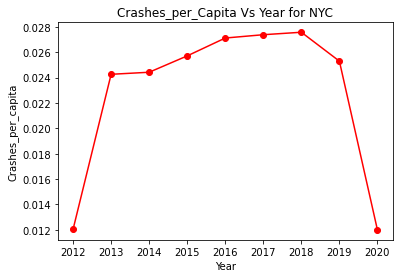

In [43]:
plot_crashes_per_capita_vs_year(crashes_population)

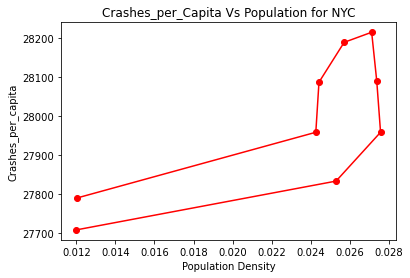

In [44]:
plot_crashes_per_capita_vs_population_density(crashes_population)

In [45]:
crashes_population_subset = crashes_population.drop([0,8],0)

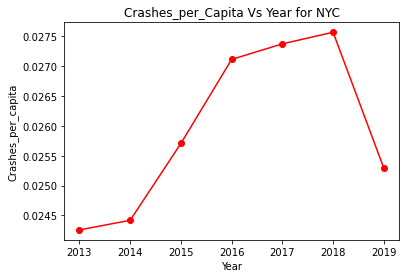

In [46]:
plot_crashes_per_capita_vs_year(crashes_population_subset)

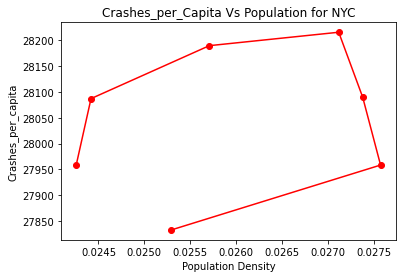

In [47]:
plot_crashes_per_capita_vs_population_density(crashes_population_subset)

## Hypothesis

#### Crash locations are not random. The collisions are bound to specific areas due to a badly planned network of roads/traffic signs.

In [48]:
mapbox_access_token = 'pk.eyJ1IjoiYWdhcndhbGFkYXJzaCIsImEiOiJja2h5ZGYyd3UwZTN3MnFwYzM1YW9qNnFvIn0.SasVV15822weUxlZ3G0P8Q'

In [210]:
Zipcode_geojson = 'zipcode.geojson'

In [209]:
def set_up_crashes_for_map(crashes, geojson_filename):
    with open(geojson_filename) as f:
        gj = geojson.load(f)
        for feature in gj['features']:
            zipcode = feature['properties']['postalCode']
            feature['id'] = zipcode

    crashes_per_zipcode = crashes.groupby(['ZIP CODE'], sort=True).size().reset_index(name='crashes_per_zipcode')
    crashes_per_zipcode = crashes_per_zipcode.rename(columns={'ZIP CODE': 'zipcode'})
    crashes_per_zipcode.drop(crashes_per_zipcode[(crashes_per_zipcode['zipcode'].isna()) |
                                                 (crashes_per_zipcode['zipcode'] == "     ")].index, inplace=True)
    return crashes_per_zipcode, gj

In [213]:
def plot_crash_locations(mapbox_access_token, crashes_per_zipcode, gj):

    fig = px.choropleth_mapbox(crashes_per_zipcode, geojson=gj, locations='zipcode', color='crashes_per_zipcode',
                               color_continuous_scale="Viridis",
                               range_color=(0, 15000),
                               mapbox_style="carto-positron",
                               zoom=9, center={"lat": 40.74, "lon": -73.8},
                               opacity=0.5
                               )
    fig.update_layout(mapbox_style="light",
                      mapbox_accesstoken=mapbox_access_token,
                      margin={"r": 0, "t": 0, "l": 0, "b": 0})
    fig.show()

In [211]:
crashes_per_zipcode, gj = set_up_crashes_for_map(crashes, Zipcode_geojson)

In [214]:
plot_crash_locations(mapbox_access_token, crashes_per_zipcode, gj)